Version 2: Predict the percentage change interval of next day

### 1. Preparation

In [369]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import random

In [370]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(42)

### 2. Data Loading & Preprocessing

**Helper Functions**

In [371]:
def load_from_yf(ticker, period="10y", interval="1d"):
    df: pd.DataFrame = yf.Ticker(ticker).history(period=period, interval=interval)
    return df[["Open", "High", "Low", "Close"]], df[["Volume"]]

In [372]:
def normalized(df):
    return (df - df.mean()) / df.std()

def denormalized(df, value):
    return value * df.std() + df.mean()

**Input Data**

In [373]:
price, vol = load_from_yf("TSLA")

n_price = normalized(np.log(price))
n_vol = normalized(vol)

data = np.concatenate([n_price, n_vol], axis=1)
print(data, "\n")
print(np.exp(denormalized(np.log(price), 2.13067623)), "\n")

[[-1.74795281 -1.74527011 -1.753819   -1.75512962 -1.09096267]
 [-1.74409011 -1.7551401  -1.75545843 -1.75168792 -1.15969677]
 [-1.75619725 -1.76285474 -1.77348639 -1.78299409 -1.07921187]
 ...
 [ 2.13571844  2.136147    2.13132584  2.1383959  -0.32857755]
 [ 2.12897885  2.11578523  2.13200411  2.1149337  -0.62151037]
 [ 2.08121104  2.08591425  2.09512836  2.07684145 -0.57260418]] 

Open     1045.514409
High     1068.953239
Low      1020.678726
Close    1046.699678
dtype: float64 



**Label Data**

[0.24395054] [-0.21062826]
{0: 69, 1: 114, 2: 283, 3: 674, 4: 697, 5: 335, 6: 118, 7: 107}


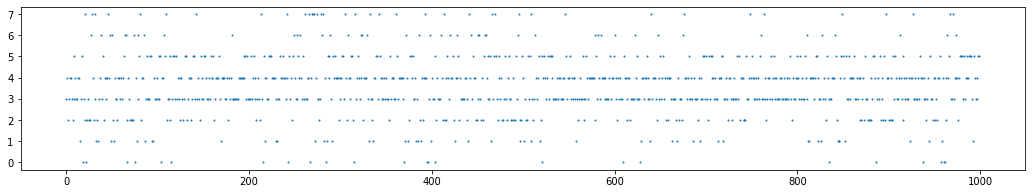

In [374]:
close = price[["Close"]].to_numpy()

change = []
for i in range(len(close)):
    change.append(0 if (i==0) else (close[i]-close[i-1])/close[i-1])
    
print(max(change), min(change))

label = []
for i in range(len(close)):
    if change[i] <= -0.06:   cat = 0
    elif change[i] <= -0.04: cat = 1
    elif change[i] <= -0.02: cat = 2
    elif change[i] <= 0:     cat = 3
    elif change[i] <= 0.02:  cat = 4
    elif change[i] <= 0.04:  cat = 5
    elif change[i] <= 0.06:  cat = 6
    elif change[i] >  0.06:  cat = 7
    label.append(cat)

unique, counts = np.unique(label[120:], return_counts=True) 
print(dict(zip(unique, counts)))

plt.figure(figsize=(18,3))
plt.scatter(range(1000), label[:1000], s=1)
plt.show()

### 3. Model

In [375]:
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__() # 120
        self.fc1 = nn.Linear(in_features=600, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=1000)
        self.fc3 = nn.Linear(in_features=1000, out_features=8)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input):
        input = nn.Flatten()(input)
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.softmax(x)
        return x

In [376]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__() # 120
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=64, kernel_size=5) # 116
        self.maxp1 = nn.MaxPool1d(kernel_size=2, stride=2) # 58
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5) # 54
        self.maxp2 = nn.MaxPool1d(kernel_size=2, stride=2) # 27
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=20, kernel_size=5) # 23
        self.flatten = nn.Flatten()
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(in_features=460, out_features=20)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=20, out_features=8)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input):
        x = self.maxp1(self.conv1(input))
        x = self.maxp2(self.conv2(x))
        x = self.flatten(self.conv3(x))
        x = self.fc1(self.relu1(x))
        x = self.fc2(self.relu2(x))
        x = self.softmax(x)
        return x

In [377]:
net = FCNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

**Training**

In [378]:
trainlosslist = []
testlosslist = []
for epoch in range(10):
    epochstart = time.time()

    trainloss = 0
    for i in range(2000):
        step_start = time.time()
        optimizer.zero_grad()

        input = torch.tensor([data[i:i+120]]).float().permute(0,2,1)
        target = torch.tensor([label[i+120]])
        output = net(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    trainlosslist.append(trainloss)

    trainloss = 0
    traincorrect = 0
    with torch.no_grad():
        for i in range(2000):
            input = torch.tensor([data[i:i+120]]).float().permute(0,2,1)
            target = torch.tensor([label[i+120]])
            output = net(input)
            loss = criterion(output, target)
            trainloss += loss.item()

            _, predicted = torch.max(output.data, 1)
            traincorrect += (predicted == target).sum().item()
    
    testloss = 0
    testcorrect = 0
    with torch.no_grad():
        for i in range(2000, 2300):
            input = torch.tensor([data[i:i+120]]).float().permute(0,2,1)
            target = torch.tensor([label[i+120]])
            output = net(input)
            loss = criterion(output, target)
            testloss += loss.item()
            
            _, predicted = torch.max(output.data, 1)
            testcorrect += (predicted == target).sum().item()
    testlosslist.append(testloss)

    epochtime = time.time() - epochstart
    print(f"Epoch {epoch+1:2d} | Train loss: {(trainloss):7.2f} | Train acc: {(traincorrect/20):5.2f}%"
                             f"| Test avg loss: {(testloss):7.2f} | Test acc: {(testcorrect/3):5.2f}% | {epochtime:.2f}s")

Epoch  1 | Train loss: 4158.88 | Train acc:  2.70%| Test avg loss:  623.83 | Test acc:  3.33% | 20.57s
Epoch  2 | Train loss: 4158.88 | Train acc:  2.70%| Test avg loss:  623.83 | Test acc:  3.33% | 19.66s
Epoch  3 | Train loss: 4158.88 | Train acc:  2.70%| Test avg loss:  623.83 | Test acc:  3.33% | 20.88s


KeyboardInterrupt: 

### 4. Evaluation

IndentationError: expected an indented block (1602265435.py, line 3)